In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torchvision.transforms import ToTensor
from tqdm import tqdm
import cv2
import os
from torch.utils.data import TensorDataset, DataLoader


In [2]:

root_dir = r'C:\Users\User\Desktop\UAB\2nd year\2nd semester\neural network-deep learning\project'  # Ruta del directorio de imágenes

N_IDC = []
P_IDC = []

for dir_name in tqdm(os.listdir(root_dir)):
    dir_path = os.path.join(root_dir, dir_name)
    if os.path.isdir(dir_path):
        negative_dir_path = os.path.join(dir_path, '0')
        positive_dir_path = os.path.join(dir_path, '1')
        if os.path.isdir(negative_dir_path) and os.path.isdir(positive_dir_path):
            negative_image_paths = [
                os.path.join(negative_dir_path, image_name)
                for image_name in os.listdir(negative_dir_path)
                if image_name.endswith('.png')
            ]
            positive_image_paths = [
                os.path.join(positive_dir_path, image_name)
                for image_name in os.listdir(positive_dir_path)
                if image_name.endswith('.png')
            ]
            N_IDC.extend(negative_image_paths)
            P_IDC.extend(positive_image_paths)

total_images = 5000  # Cambiado a 5000 para equilibrar las clases (2500 benignos y 2500 malignos)

n_img_arr = np.zeros(shape=(total_images, 50, 50, 3), dtype=np.float32)
p_img_arr = np.zeros(shape=(total_images, 50, 50, 3), dtype=np.float32)
label_n = np.zeros(total_images)
label_p = np.ones(total_images)

for i, img in tqdm(enumerate(N_IDC[:total_images])):
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    n_img_arr[i] = n_img_size

for i, img in tqdm(enumerate(P_IDC[:total_images])):
    p_img = cv2.imread(img, cv2.IMREAD_COLOR)
    p_img_size = cv2.resize(p_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    p_img_arr[i] = p_img_size

X = np.concatenate((p_img_arr, n_img_arr), axis=0)
y = np.concatenate((label_p, label_n), axis=0)
X, y = shuffle(X, y, random_state=0)

# probar --> y = to_categorical(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


100%|██████████| 285/285 [00:32<00:00,  8.77it/s]
5000it [00:22, 227.14it/s]
5000it [00:15, 324.47it/s]


In [3]:


class CNN(nn.Module):
    def __init__(self, output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12 * 12 * 64, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64, 24)
        self.fc4 = nn.Linear(24, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x


torch.backends.cudnn.benchmark = True
learning_rate = 0.001 #1e-2
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss() 
# probar --> criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
#optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    return train_loss

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [5]:

batch_size = 32  # Define the batch size
train_dataset = TensorDataset(torch.from_numpy(X_train).float().permute(0, 3, 1, 2), torch.from_numpy(y_train).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float().permute(0, 3, 1, 2), torch.from_numpy(y_val).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, device, val_loader, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print('Epoch: {:02d}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'.format(
        epoch, train_loss, val_loss, val_accuracy))

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))



Epoch: 00, Train Loss: 0.4752, Val Loss: 0.4641, Val Accuracy: 84.33%
Epoch: 01, Train Loss: 0.4441, Val Loss: 0.4686, Val Accuracy: 82.78%
Epoch: 02, Train Loss: 0.4435, Val Loss: 0.4447, Val Accuracy: 86.39%
Epoch: 03, Train Loss: 0.4377, Val Loss: 0.5693, Val Accuracy: 73.06%
Epoch: 04, Train Loss: 0.4358, Val Loss: 0.4459, Val Accuracy: 86.11%
Epoch: 05, Train Loss: 0.4364, Val Loss: 0.6046, Val Accuracy: 70.72%
Epoch: 06, Train Loss: 0.4331, Val Loss: 0.4413, Val Accuracy: 86.44%
Epoch: 07, Train Loss: 0.4314, Val Loss: 0.4713, Val Accuracy: 83.67%
Epoch: 08, Train Loss: 0.4331, Val Loss: 0.4362, Val Accuracy: 87.11%
Epoch: 09, Train Loss: 0.4303, Val Loss: 0.5170, Val Accuracy: 78.06%
Epoch: 10, Train Loss: 0.4276, Val Loss: 0.4743, Val Accuracy: 82.11%
Epoch: 11, Train Loss: 0.4262, Val Loss: 0.4354, Val Accuracy: 87.06%
Epoch: 12, Train Loss: 0.4242, Val Loss: 0.4730, Val Accuracy: 83.33%
Epoch: 13, Train Loss: 0.4236, Val Loss: 0.4548, Val Accuracy: 85.50%
Epoch: 14, Train Los

<All keys matched successfully>

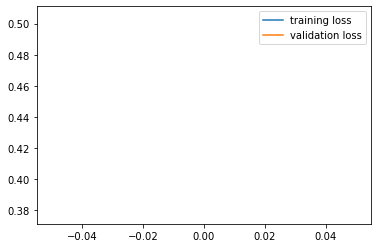

In [6]:
plt.plot(train_loss, label="training loss")
plt.plot(val_loss, label="validation loss")

plt.legend()
plt.pause(0.000001)
plt.show()

In [7]:
# Evaluate on the test set
test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 3, 1, 2), torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate(model, device, test_loader, criterion)

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.4403, Test Accuracy: 87.30%
